This notebook is focussed on the link prediction task. 

I will be loading the embeddings learnt using the node2vec on the 3 datasets (countries, cities and combined) in combination with the 3 different strategies (deepwalk, bfs and dfs). The graph provides no true values for supervised learning, so to overcome that, I will create a dataset with negative examples: a permutation of edges that would never occur when following the rules of the game, and use that to learn a predicitve model. After merging the positive and negative examples, I would split the dataset into training, validation and testing sets. Then I would use two approaches for the prediction task.

First I would use concat MLP, where I would concat the node2vec embeddings for a pair of nodes to get the edge embeddings and pass it through an MLP against the true values. I would compare the models based on prediction accuracy for each of the 9 embeddings we have.

Next I would use the GraphSAGE GNN. Unlike, the above model which solely uses the node2vec embeddings as input, here I would construct a feature set for each node comprising of the first and last character. Along with the edge data, I would pass the node features to a two layer GraphSAGE convolutions. For a pair of node embeddings obtained this way, I would use a HADAMARD followed by SUM operation to calculate the edge embeddings that I would train against the true values. I have taken inspiration from here: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/graph_sage_unsup.py (an example provided by the PyG framework)

Let me start by importing the required packages.

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn.conv import SAGEConv
from sklearn.metrics import roc_auc_score

Loading the calculated node2vec embeddings

In [2]:
models = {
    'node2vec_countries_dw': torch.load('data/emb/node2vec_countries_dw.pt'),
    'node2vec_countries_bfs': torch.load('data/emb/node2vec_countries_bfs.pt'),
    'node2vec_countries_dfs': torch.load('data/emb/node2vec_countries_dfs.pt'),
    'node2vec_cities_dw': torch.load('data/emb/node2vec_cities_dw.pt'),
    'node2vec_cities_bfs': torch.load('data/emb/node2vec_cities_bfs.pt'),
    'node2vec_cities_dfs': torch.load('data/emb/node2vec_cities_dfs.pt'),
    'node2vec_combined_dw': torch.load('data/emb/node2vec_combined_dw.pt'),
    'node2vec_combined_bfs': torch.load('data/emb/node2vec_combined_bfs.pt'),
    'node2vec_combined_dfs': torch.load('data/emb/node2vec_combined_dfs.pt')
}

Loading the nodes and edges data

In [3]:
nodes_countries_df = pd.read_csv('data/csv/nodes_countries.csv')
nodes_cities_df = pd.read_csv('data/csv/nodes_cities.csv')
nodes_combined_df = pd.read_csv('data/csv/nodes_combined.csv')

edges_countries_tensor = torch.load('data/pt/countries_fully_connected_edges.pt').t()
edges_cities_tensor = torch.load('data/pt/cities_fully_connected_edges.pt').t()
edges_combined_tensor = torch.load('data/pt/combined_fully_connected_edges.pt').t()

nodes_countries_tensor = edges_countries_tensor.clone().flatten().unique()
nodes_cities_tensor = edges_countries_tensor.clone().flatten().unique()
nodes_combined_tensor = edges_countries_tensor.clone().flatten().unique()

So, to get the negative examples, I decided to create a negative permutation of pairs of nodes that would never form an edge under the rules of the game: ATLAS. Here, the code makes sure that the size of negative samples match the size of positive examples. I believe this balance would help prevent underfitting of the model. And I am going to do this for all the datasets (countries, cities and combined).

PyG provides a way to fetch negative samples (as mentioned here: https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.LinkNeighborLoader), however the documentation mentions that it is approximate and may contain false negatives. So, the unsupervised training objective here is inspired from this example provided by PyG (https://github.com/pyg-team/pytorch_geometric/blob/master/examples/graph_sage_unsup.py) and I will creating negative samples as described above and defined in code below.

In [4]:
def gen_neg_edges(edge_list, node_list):
    neg_edge_list = []
    while len(neg_edge_list) != len(edge_list):
        # print(len(neg_edge_list))
        neg_edge = (random.randint(0,len(node_list)-1),random.randint(0,len(node_list)-1))
        if neg_edge not in edge_list:
            if neg_edge not in neg_edge_list:
                neg_edge_list.append(neg_edge)
    return torch.tensor(neg_edge_list)

neg_edges_countries = gen_neg_edges(
    [(e[0].item(),e[1].item()) for e in edges_countries_tensor.t()], list(nodes_countries_df['name'])
)

neg_edges_cities = gen_neg_edges(
    [(e[0].item(),e[1].item()) for e in edges_cities_tensor.t()], list(nodes_cities_df['name'])
)

neg_edges_combined = gen_neg_edges(
    [(e[0].item(),e[1].item()) for e in edges_combined_tensor.t()], list(nodes_combined_df['name'])
)

Let me print out some of the negative examples to make sure they are not possible to form edges under the rules of the game.

In [5]:
# def print_edges(edges, places):
#     for edge in edges[:10]: print(edge[0], 'to', edge[1], places[edge[0]], 'to',  places[edge[1]])

# print_edges(neg_edges_countries, list(nodes_countries_df['name']))
# print_edges(neg_edges_cities, list(nodes_cities_df['name']))
# print_edges(neg_edges_combined, list(nodes_combined_df['name']))

The function split_train_test_val below does more than just splitting the data. First it adds the y value to the dataset. 1 for positive examples and 0 for negative examples. Then it concatenates the postive and negative examples. Next I create a random shuffling of the training, validation and testing masks (with a distribution of 65%, 25% and 10% respectively), using which I split the data and return it.

In [6]:
def split_x_and_y(link_data, mask, emb):
    data = link_data[mask]
    data_y = data.t()[2].to(torch.float)
    if emb is not None:
        data_x = []
        for x in data: data_x.append(torch.cat((emb[x[0].item()],emb[x[1].item()])).detach().cpu())
        data_x = torch.tensor(np.array(data_x))
    else: data_x = data.t()[:2]
    return data, data_x, data_y#.unsqueeze(dim=-1)

def split_train_test_val(edge_index, neg_edge_list, emb=None):
    y = torch.tensor([1 for e in edge_index.t()] + [0 for e in neg_edge_list])
    x = torch.cat((edge_index.t(), neg_edge_list))
    link_data = []
    for i in range(len(y)):
        if emb is not None:
            if x[i][0]>=len(emb): print('check');continue
            if x[i][1]>=len(emb): print('check');continue
        link_data.append((x[i][0],x[i][1],y[i]))
    link_data = torch.tensor(link_data)
    
    mask = random.choices(['train','val','test'], weights=[0.65,0.25,0.1], k=len(link_data))
    
    train_mask = torch.zeros(size=(len(mask),), dtype=torch.bool)
    val_mask = torch.zeros(size=(len(mask),), dtype=torch.bool)
    test_mask = torch.zeros(size=(len(mask),), dtype=torch.bool)
    for m in range(len(mask)):
        if mask[m]=='train': train_mask[m] = True
        elif mask[m]=='val': val_mask[m] = True
        elif mask[m]=='test': test_mask[m] = True
    
    train_data, train_data_x, train_data_y = split_x_and_y(link_data, train_mask, emb)
    val_data, val_data_x, val_data_y = split_x_and_y(link_data, val_mask, emb)
    test_data, test_data_x, test_data_y = split_x_and_y(link_data, test_mask, emb)

    return train_data_x, train_data_y, val_data_x, val_data_y, test_data_x, test_data_y

The code below defines the concat mlp. Although the mlp here is just a linear layer followed by a sigmoid function (we are calculating the probability of whether the given pair of nodes are forming an edge). Since it is sigmoid, for calculating the accuracy, any value above 0.5 is set to 1 and any value below is set to 0, when comparing with the true values. For validation I am using the area under curve score (ROC AUC SCORE from scikit-learn), inspired from the link prediction tutorial here: https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing (found listed here: https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html). I came across the idea for a concat mlp from the following sources:

- ROLAND: Graph Learning Framework for Dynamic Graphs (https://arxiv.org/abs/2208.07239) (Line 5 of Algorithm 1 mentions it and this is in the context of edge predictions)
- Temporal graph learning for dynamic link prediction with text in online social networks (https://link.springer.com/article/10.1007/s10994-023-06475-x) (Their code is publicly available here: https://github.com/manuel-dileo/dynamic-gnn and they make use of both HADAMARD operation as well as concat MLP in their edge predication task, more precisely, they use HADAMARD MLP)




In [7]:
class Net(torch.nn.Module):
    def __init__(self, emb_len):
        super().__init__()
        self.linear = Linear(emb_len, 1)

    def forward(self, x):
        x = self.linear(x)
        x = F.sigmoid(x)
        return x.squeeze()

    def reset_parameters(self):
        self.linear.reset_parameters()


def accuracy(y_pred, y_true, verbose=False):
    if verbose: 
        a = y_pred
        b = y_true
    y_pred = y_pred >= 0.5
    if verbose:
        c = y_pred==y_true
        print(torch.round(torch.stack((a.t(),b.t(),c.t())).t(),decimals=3))
    return ((y_pred==y_true).sum()/len(y_true)).item()*100


def link_prediction(edge_index, neg_edge_list, model_name):
    emb = models[model_name]
    link_pred = Net(emb.shape[1]*2)
    link_pred.reset_parameters()
    optimizer = torch.optim.Adam(link_pred.parameters(), lr=0.02)

    train_data_x, train_data_y, val_data_x, val_data_y, test_data_x, test_data_y = split_train_test_val(
        edge_index, neg_edge_list, emb
    )
    
    losses = []
    val_accuracies = []
    for epoch in range(200):
        link_pred.train()
        optimizer.zero_grad()
        z_train = link_pred(train_data_x)
        loss = F.binary_cross_entropy(z_train, train_data_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
        link_pred.eval()
        z_val = link_pred(val_data_x)
        # acc = accuracy(z_val, val_data_y)
        acc = roc_auc_score(val_data_y.clone().detach(), z_val.clone().detach())
        val_accuracies.append(acc)
    

    fig = plt.figure(figsize=(10,3))
    fig.clf()
    
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses)
    ax.set_title(model_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel('losses')
    ax.grid(True)
    
    ax = fig.add_subplot(1,2,2)
    ax.plot(val_accuracies)
    ax.set_title(model_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel('validation roc_auc')
    ax.grid(True)
    
    fig.tight_layout()
    
    link_pred.eval()
    z_test = link_pred(test_data_x)
    acc = roc_auc_score(test_data_y.clone().detach(), z_test.clone().detach())
    print('test roc_auc (model : '+model_name+'): '+str(f'{acc*100:.2f}'))
    print('test accuracy (model : '+model_name+'): '+str(accuracy(z_test, test_data_y, verbose=False)))

    return link_pred

test roc_auc (model : node2vec_countries_dw): 78.32
test accuracy (model : node2vec_countries_dw): 70.30162215232849
test roc_auc (model : node2vec_countries_bfs): 83.59
test accuracy (model : node2vec_countries_bfs): 79.5061707496643
test roc_auc (model : node2vec_countries_dfs): 86.04
test accuracy (model : node2vec_countries_dfs): 77.36263871192932
test roc_auc (model : node2vec_cities_dw): 79.08
test accuracy (model : node2vec_cities_dw): 73.94673228263855
test roc_auc (model : node2vec_cities_bfs): 80.68
test accuracy (model : node2vec_cities_bfs): 74.76772665977478
test roc_auc (model : node2vec_cities_dfs): 79.34
test accuracy (model : node2vec_cities_dfs): 73.10717701911926
test roc_auc (model : node2vec_combined_dw): 80.31
test accuracy (model : node2vec_combined_dw): 74.49988722801208
test roc_auc (model : node2vec_combined_bfs): 80.01
test accuracy (model : node2vec_combined_bfs): 73.72690439224243
test roc_auc (model : node2vec_combined_dfs): 80.45
test accuracy (model : no

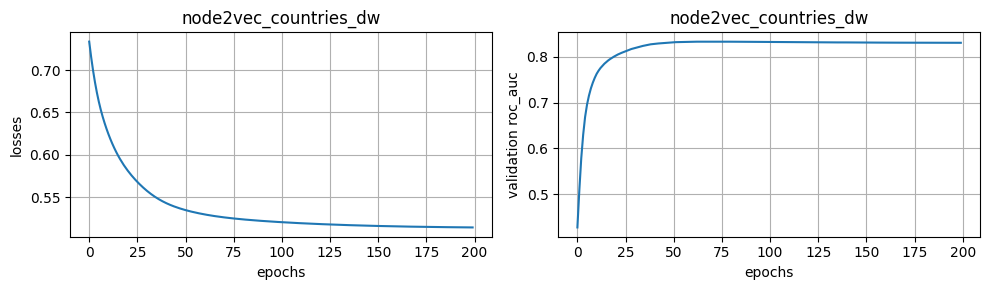

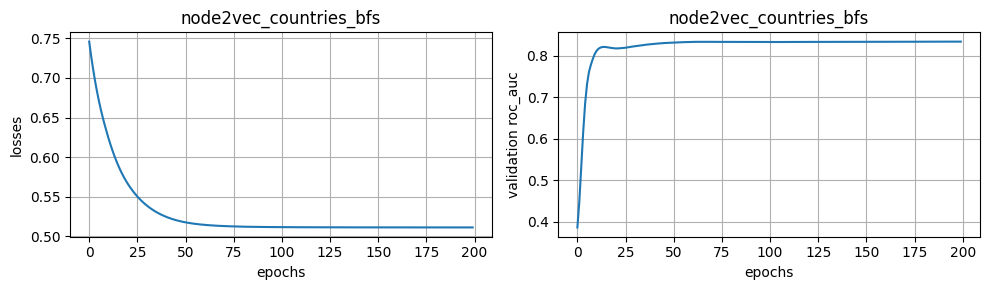

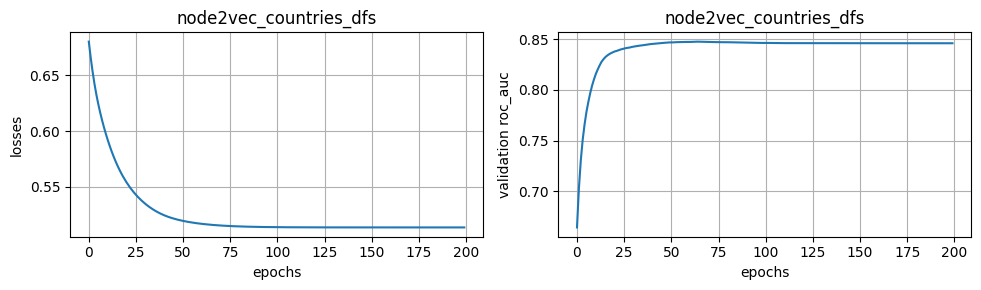

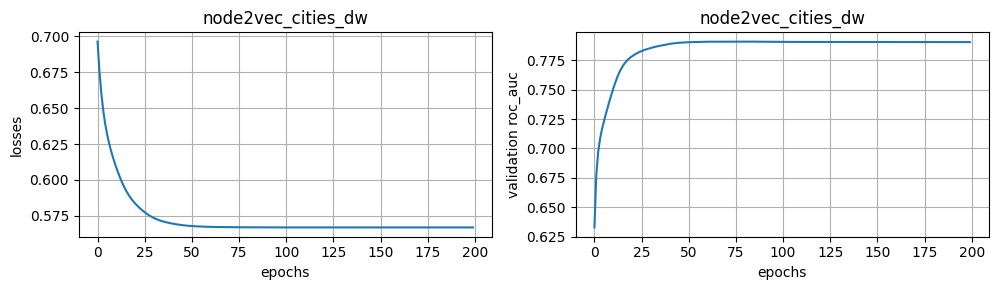

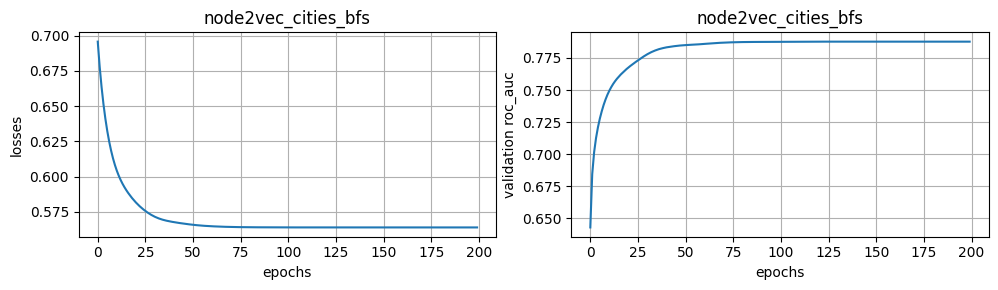

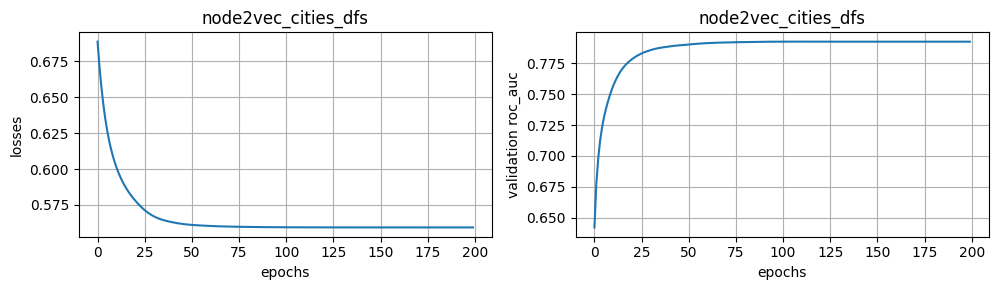

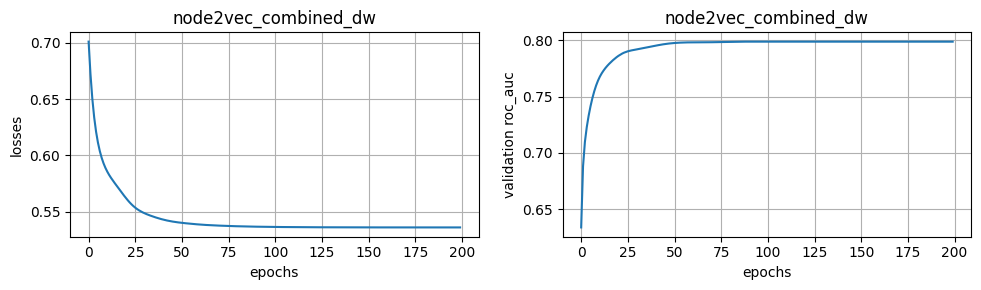

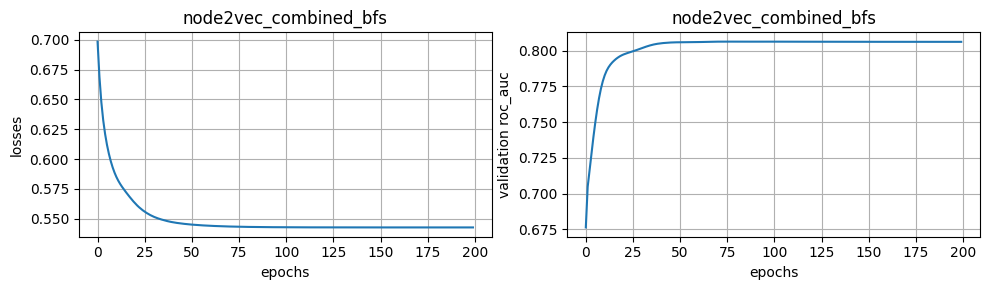

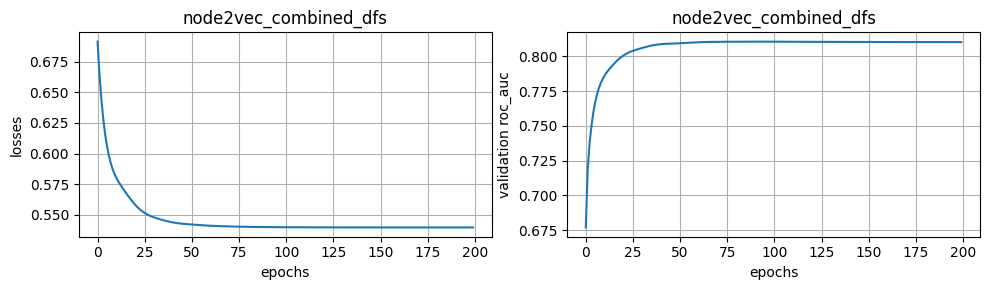

In [8]:
link_pred_countries_dw = link_prediction(edges_countries_tensor, neg_edges_countries, 'node2vec_countries_dw')
link_pred_countries_bfs = link_prediction(edges_countries_tensor, neg_edges_countries, 'node2vec_countries_bfs')
link_pred_countries_dfs = link_prediction(edges_countries_tensor, neg_edges_countries, 'node2vec_countries_dfs')

link_pred_cities_dw = link_prediction(edges_cities_tensor, neg_edges_cities, 'node2vec_cities_dw')
link_pred_cities_bfs = link_prediction(edges_cities_tensor, neg_edges_cities, 'node2vec_cities_bfs')
link_pred_cities_dfs = link_prediction(edges_cities_tensor, neg_edges_cities, 'node2vec_cities_dfs')

link_pred_combined_dw = link_prediction(edges_combined_tensor, neg_edges_combined, 'node2vec_combined_dw')
link_pred_combined_bfs = link_prediction(edges_combined_tensor, neg_edges_combined, 'node2vec_combined_bfs')
link_pred_combined_dfs = link_prediction(edges_combined_tensor, neg_edges_combined, 'node2vec_combined_dfs')

From the above plots, the reduction of the loss is fairly consistent across all the different embeddings used as input for the concat MLP with convergence occuring roughly close to 100 epochs. I chose 500 epochs to verify this consistency. The accuracies are in the ballpark of 75% to 85% for all the embeddings, with the highest for the BFS based embeddings for countries only dataset at 85.67%. And the accuracy plot is also consistent across all the different embeddings and again in roughly about 100 epoch, the accuracy peaks and flattens.

The code below creates a feature set including the first and last char of the names of places in their unicode form and normalised, for each of the countries, cities and combined datasets.

In [9]:
# torch.tensor([sum([(ord(ch)-ord('A'))/(ord('Z')-ord('A')) for ch in ph]) for ph in nodes_countries_df['phonetics']])
# F.normalize(torch.tensor([ph for ph in nodes_countries_df['phonetics_length']]).to(torch.float), dim=-1)

x_countries = torch.stack((
    (torch.tensor([ord(ch) for ch in nodes_countries_df['first_char']])-ord('A'))/(ord('Z') - ord('A')),
    (torch.tensor([ord(ch) for ch in nodes_countries_df['last_char']])-ord('A'))/(ord('Z') - ord('A'))
)).t()

x_cities = torch.stack((
    (torch.tensor([ord(ch) for ch in nodes_cities_df['first_char']])-ord('A'))/(ord('Z') - ord('A')),
    (torch.tensor([ord(ch) for ch in nodes_cities_df['last_char']])-ord('A'))/(ord('Z') - ord('A'))
)).t()

x_combined = torch.stack((
    (torch.tensor([ord(ch) for ch in nodes_combined_df['first_char']])-ord('A'))/(ord('Z') - ord('A')),
    (torch.tensor([ord(ch) for ch in nodes_combined_df['last_char']])-ord('A'))/(ord('Z') - ord('A'))
)).t()

Next, I am preparing the neural network. I would be using GraphSAGE convolution here (https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.SAGEConv.html). This is take into consideration the network structure (based on the edge information) and the node attributes (comprising of the first and last char values as set in the code above). Then the HADAMARD followed by SUM operation would be performed to obtain the embeddings for a given pair of nodes. This is inspired from the example provided by PyG documentation (available here: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/graph_sage_unsup.py). And like in the previous case, I am applying a sigmoid activation here too, and for the same reasons as above, namely, because I would be calculating the likelyhood of an edge, given a pair of nodes.

Then I would be applying the model on each of the 3 datasets.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SageNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(-1, 16)
        self.conv2 = SAGEConv(16, 8)
        self.linear = Linear(8, 1)

    def forward(self, x, edges):
        node_emb = self.conv1(x, edges)
        node_emb = F.relu(node_emb)
        node_emb = F.dropout(node_emb)
        node_emb = self.conv2(node_emb, edges)
        src = node_emb[edges[0]]
        dst = node_emb[edges[1]]
        z = torch.mul(src,dst)
        z = self.linear(z)
        z = F.sigmoid(z)
        return z.squeeze()

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.linear.reset_parameters()


def link_prediction_2(nodes, edge_index, neg_edge_list, data_name=''):
    model = SageNet()#.to(device)
    model.reset_parameters()

    train_data_x, train_data_y, val_data_x, val_data_y, test_data_x, test_data_y = split_train_test_val(
        edge_index, neg_edge_list
    )    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    losses = []
    val_accuracies = []
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        z_train = model(nodes, train_data_x)
        loss = F.binary_cross_entropy(z_train, train_data_y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
        model.eval()
        z_val = model(nodes, val_data_x)
        # acc = accuracy(z_val, val_data_y)
        acc = roc_auc_score(val_data_y.clone().detach(), z_val.clone().detach())
        val_accuracies.append(acc)

    fig = plt.figure(figsize=(10,3))
    fig.clf()
    
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses)
    ax.set_title('SageNet '+data_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel('losses')
    ax.grid(True)
    
    ax = fig.add_subplot(1,2,2)
    ax.plot(val_accuracies)
    ax.set_title('SageNet '+data_name)
    ax.set_xlabel('epochs')
    ax.set_ylabel('validation roc_auc')
    ax.grid(True)
    
    fig.tight_layout()
    
    model.eval()
    z_test = model(nodes, test_data_x)
    acc = roc_auc_score(test_data_y.clone().detach(), z_test.clone().detach())
    print('test roc_auc (model : SageNet, data : '+data_name+'): '+str(f'{acc*100:.2f}'))
    print('test accuracy (model : SageNet, data : '+data_name+'): '+str(accuracy(z_test, test_data_y, verbose=False)))

    return model
    

test roc_auc (model : SageNet, data : countries): 69.98
test accuracy (model : SageNet, data : countries): 63.28502297401428
test roc_auc (model : SageNet, data : cities): 67.98
test accuracy (model : SageNet, data : cities): 62.54940629005432
test roc_auc (model : SageNet, data : combined): 69.24
test accuracy (model : SageNet, data : combined): 63.77989053726196


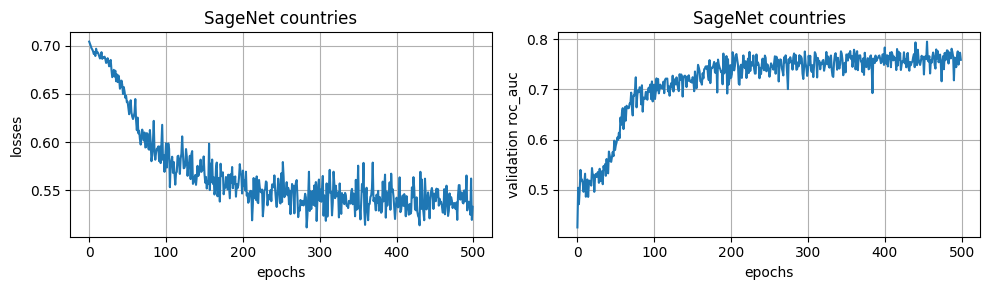

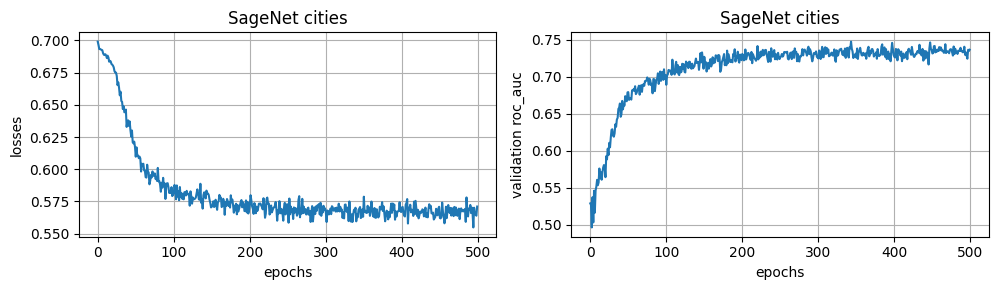

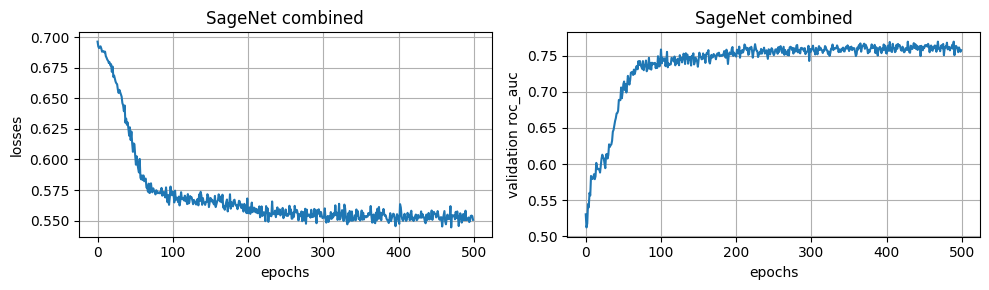

In [11]:
link_pred_countries_2 = link_prediction_2(x_countries, edges_countries_tensor, neg_edges_countries, 'countries')
link_pred_cities_2 = link_prediction_2(x_cities, edges_cities_tensor, neg_edges_cities, 'cities')
link_pred_combined_2 = link_prediction_2(x_combined, edges_combined_tensor, neg_edges_combined, 'combined')

It appears that the accuracy here, which is in the range of 50% to 60%, is less than 70% to 80% which we say earliar, when were predicting the likelyhood of edges based on node2vec edge emdeddings. The plot of losses for the cities and combined data is smoother than that of the countries data. More data helps I guess. On thing that can be done in that case, would be to change the training split size and see if it improves. But, otherwise, my guess is that, here the convolution involves 2 degrees of message passing which is less than the extent of random walks done when the node2vec embeddings were being optimized. Hence, node2vec embeddings (irrespective of the search bias values) capture the neighbourhood to a larger extent than SageConv and that might explain the difference in the accuracies observed above.